# 환경 세팅

In [1]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? n


In [2]:
!pip install tensorflow==2.15.0

In [3]:
!pip uninstall tensorflow_decision_forests

In [4]:
!pip install tensorflow_decision_forests==1.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 67.7 MB/s eta 0:00:00


In [5]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


# 학습/검증 데이터 수집

In [6]:
# 그 전에 mount하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

In [8]:
import pandas as pd
import numpy as np

# 2005

data05 = pd.read_sas('/content/drive/MyDrive/datasets/hn05_all.sas7bdat', format = 'sas7bdat')

selected05 = data05[['DI1_dg', 'sex', 'age', 'HE_SBP', 'HE_DBP', 'HE_PLS']]
selected05.rename(columns={'HE_SBP': 'HE_sbp'}, inplace=True)
selected05.rename(columns={'HE_DBP': 'HE_dbp'}, inplace=True)

# 체질량지수가 존재하지 않아 키와 체중 값을 사용해 가공 (신장 : HE_HT, 체중: HE_WT)
selected05['HE_BMI'] = data05['HE_WT'] / ((data05['HE_HT'] / 100) ** 2)

#흡연 여부
selected05['sm_present'] = ((data05['BS1_1'].isin([1, 2])) & (data05['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
selected05['pa_walk'] = (data05['BE3_31'].isin([4, 5, 6, 7, 8]) & data05['BE3_32'].isin([3, 4, 5, 6])).astype(int)

# 하루 평균 수면시간 : BR1 (모름 : 99)
selected05['total_sleep'] = np.where(data05['BR1'].isin([99]), None, data05['BR1'])

print(selected05.shape)
selected05 = selected05.dropna()
idx = selected05[selected05['DI1_dg'] == 8].index
selected05 = selected05.drop(idx)
print(selected05.shape)


# 07 / 08 / 09

data07 = pd.read_sas('/content/drive/MyDrive/datasets/hn07_all.sas7bdat', format = 'sas7bdat')

selected07 = data07[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected07['sm_present'] = ((data07['BS1_1'].isin([1, 2])) & (data07['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data07['pa_hb30_1'] = np.where((data07['BE3_32'].isin([88,99]) | data07['BE3_33'].isin([88,99])), 0, data07['BE3_32'] * 60 + data07['BE3_33'])
selected07['pa_walk'] = (data07['BE3_31'].isin([4, 5, 6, 7, 8]) & (data07['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (모름 : 99)
selected07['total_sleep'] = np.where(data07['BP8'].isin([99]), None, data07['BP8'])

print(selected07.shape)
selected07 = selected07.dropna()
idx = selected07[selected07['DI1_dg'] == 8].index
selected07 = selected07.drop(idx)
print(selected07.shape)
print('-' * 20)


data08 = pd.read_sas('/content/drive/MyDrive/datasets/hn08_all.sas7bdat', format = 'sas7bdat')

selected08 = data08[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected08['sm_present'] = ((data08['BS1_1'].isin([1, 2])) & (data08['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data08['pa_hb30_1'] = np.where((data08['BE3_32'].isin([88,99]) | data08['BE3_33'].isin([88,99])), 0, data08['BE3_32'] * 60 + data08['BE3_33'])
selected08['pa_walk'] = (data08['BE3_31'].isin([4, 5, 6, 7, 8]) & (data08['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (모름 : 99)
selected08['total_sleep'] = np.where(data08['BP8'].isin([99]), None, data08['BP8'])

print(selected08.shape)
selected08 = selected08.dropna()
idx = selected08[selected08['DI1_dg'] == 8].index
selected08 = selected08.drop(idx)
print(selected08.shape)
print('-' * 20)


data09 = pd.read_sas('/content/drive/MyDrive/datasets/hn09_all.sas7bdat', format = 'sas7bdat')

selected09 = data09[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected09['sm_present'] = ((data09['BS1_1'].isin([1, 2])) & (data09['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data09['pa_hb30_1'] = np.where((data09['BE3_32'].isin([88,99]) | data09['BE3_33'].isin([88,99])), 0, data09['BE3_32'] * 60 + data09['BE3_33'])
selected09['pa_walk'] = (data09['BE3_31'].isin([4, 5, 6, 7, 8]) & (data09['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (모름 : 99)
selected09['total_sleep'] = np.where(data09['BP8'].isin([99]), None, data09['BP8'])

print(selected09.shape)
selected09 = selected09.dropna()
idx = selected09[selected09['DI1_dg'] == 8].index
selected09 = selected09.drop(idx)
print(selected09.shape)


# 10 / 11 / 12
data10 = pd.read_sas('/content/drive/MyDrive/datasets/hn10_all.sas7bdat', format = 'sas7bdat')

selected10 = data10[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected10['sm_present'] = ((data10['BS1_1'].isin([1, 2])) & (data10['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data10['pa_hb30_1'] = np.where((data10['BE3_32'].isin([88,99]) | data10['BE3_33'].isin([88,99])), 0, data10['BE3_32'] * 60 + data10['BE3_33'])
selected10['pa_walk'] = (data10['BE3_31'].isin([4, 5, 6, 7, 8]) & (data10['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (비해당 : 88, 모름 : 99)
selected10['total_sleep'] = np.where(data10['BP8'].isin([88, 99]), None, data10['BP8'])

print(selected10.shape)
selected10 = selected10.dropna()
idx = selected10[selected10['DI1_dg'] == 8].index
selected10 = selected10.drop(idx)
print(selected10.shape)
print('-' * 20)


data11 = pd.read_sas('/content/drive/MyDrive/datasets/hn11_all.sas7bdat', format = 'sas7bdat')

selected11 = data11[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected11['sm_present'] = ((data11['BS1_1'].isin([1, 2])) & (data11['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data11['pa_hb30_1'] = np.where((data11['BE3_32'].isin([88,99]) | data11['BE3_33'].isin([88,99])), 0, data11['BE3_32'] * 60 + data11['BE3_33'])
selected11['pa_walk'] = (data11['BE3_31'].isin([4, 5, 6, 7, 8]) & (data11['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (비해당 : 88, 모름 : 99)
selected11['total_sleep'] = np.where(data11['BP8'].isin([88, 99]), None, data11['BP8'])

print(selected11.shape)
selected11 = selected11.dropna()
idx = selected11[selected11['DI1_dg'] == 8].index
selected11 = selected11.drop(idx)
print(selected11.shape)
print('-' * 20)


data12 = pd.read_sas('/content/drive/MyDrive/datasets/hn12_all.sas7bdat', format = 'sas7bdat')

selected12 = data12[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected12['sm_present'] = ((data12['BS1_1'].isin([1, 2])) & (data12['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data12['pa_hb30_1'] = np.where((data12['BE3_32'].isin([88,99]) | data12['BE3_33'].isin([88,99])), 0, data12['BE3_32'] * 60 + data12['BE3_33'])
selected12['pa_walk'] = (data12['BE3_31'].isin([4, 5, 6, 7, 8]) & (data12['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (비해당 : 88, 모름 : 99)
selected12['total_sleep'] = np.where(data12['BP8'].isin([88, 99]), None, data12['BP8'])

print(selected12.shape)
selected12 = selected12.dropna()
idx = selected12[selected12['DI1_dg'] == 8].index
selected12 = selected12.drop(idx)
print(selected12.shape)


# 13 / 14 / 15

data13 = pd.read_sas('/content/drive/MyDrive/datasets/hn13_all.sas7bdat', format = 'sas7bdat')

selected13 = data13[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected13['sm_present'] = ((data13['BS1_1'].isin([1, 2])) & (data13['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data13['pa_hb30_1'] = np.where((data13['BE3_32'].isin([88,99]) | data13['BE3_33'].isin([88,99])), 0, data13['BE3_32'] * 60 + data13['BE3_33'])
selected13['pa_walk'] = (data13['BE3_31'].isin([4, 5, 6, 7, 8]) & (data13['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (비해당 : 88, 모름 : 99)
selected13['total_sleep'] = np.where(data13['BP8'].isin([88, 99]), None, data13['BP8'])

print(selected13.shape)
selected13 = selected13.dropna()
idx = selected13[selected13['DI1_dg'] == 8].index
selected13 = selected13.drop(idx)
print(selected13.shape)
print('-' * 20)


data14 = pd.read_sas('/content/drive/MyDrive/datasets/hn14_all.sas7bdat', format = 'sas7bdat')

selected14 = data14[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected14['sm_present'] = ((data14['BS1_1'].isin([1, 2])) & (data14['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data14['pa_hb30_1'] = np.where((data14['BE3_32'].isin([88,99]) | data14['BE3_33'].isin([88,99])), 0, data14['BE3_32'] * 60 + data14['BE3_33'])
selected14['pa_walk'] = (data14['BE3_31'].isin([4, 5, 6, 7, 8]) & (data14['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (비해당 : 88, 모름 : 99)
selected14['total_sleep'] = np.where(data14['BP8'].isin([88, 99]), None, data14['BP8'])

print(selected14.shape)
selected14 = selected14.dropna()
idx = selected14[selected14['DI1_dg'] == 8].index
selected14 = selected14.drop(idx)
print(selected14.shape)
print('-' * 20)


data15 = pd.read_sas('/content/drive/MyDrive/datasets/hn15_all.sas7bdat', format = 'sas7bdat')

selected15 = data15[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected15['sm_present'] = ((data15['BS1_1'].isin([1, 2])) & (data15['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주3회 이상 걷기 운동을 30분이상 실천한 여부
data15['pa_hb30_1'] = np.where((data15['BE3_32'].isin([88,99]) | data15['BE3_33'].isin([88,99])), 0, data15['BE3_32'] * 60 + data15['BE3_33'])
selected15['pa_walk'] = (data15['BE3_31'].isin([4, 5, 6, 7, 8]) & (data15['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : BP8 (비해당 : 88, 모름 : 99)
selected15['total_sleep'] = np.where(data15['BP8'].isin([88, 99]), None, data15['BP8'])

print(selected15.shape)
selected15 = selected15.dropna()
idx = selected15[selected15['DI1_dg'] == 8].index
selected15 = selected15.drop(idx)
print(selected15.shape)


# 16 / 17 / 18

data16 = pd.read_sas('/content/drive/MyDrive/datasets/hn16_all.sas7bdat', format = 'sas7bdat')

selected16 = data16[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected16['sm_present'] = ((data16['BS1_1'].isin([1, 2])) & (data16['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data16['pa_hb30_1'] = np.where((data16['BE3_32'].isin([88,99]) | data16['BE3_33'].isin([88,99])), 0, data16['BE3_32'] * 60 + data16['BE3_33'])
selected16['pa_walk'] = (data16['BE3_31'].isin([4, 5, 6, 7, 8]) & (data16['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : Total_slp_wk (모름 : 99)
selected16['total_sleep'] = np.where(data16['Total_slp_wk'].isin([8888, 9999]), None, data16['Total_slp_wk'] / 60)

print(selected16.shape)
selected16 = selected16.dropna()
idx = selected16[selected16['DI1_dg'] == 8].index
selected16 = selected16.drop(idx)
print(selected16.shape)


data17 = pd.read_sas('/content/drive/MyDrive/datasets/hn17_all.sas7bdat', format = 'sas7bdat')

selected17 = data17[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected17['sm_present'] = ((data17['BS1_1'].isin([1, 2])) & (data17['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data17['pa_hb30_1'] = np.where((data17['BE3_32'].isin([88,99]) | data17['BE3_33'].isin([88,99])), 0, data17['BE3_32'] * 60 + data17['BE3_33'])
selected17['pa_walk'] = (data17['BE3_31'].isin([4, 5, 6, 7, 8]) & (data17['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : Total_slp_wk (모름 : 99)
selected17['total_sleep'] = np.where(data17['Total_slp_wk'].isin([8888, 9999]), None, data17['Total_slp_wk'] / 60)

print(selected17.shape)
selected17 = selected17.dropna()
idx = selected17[selected17['DI1_dg'] == 8].index
selected17 = selected17.drop(idx)
print(selected17.shape)


data18 = pd.read_sas('/content/drive/MyDrive/datasets/hn18_all.sas7bdat', format = 'sas7bdat')

selected18 = data18[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS', 'HE_BMI']]

#흡연 여부
selected18['sm_present'] = ((data18['BS1_1'].isin([1, 2])) & (data18['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data18['pa_hb30_1'] = np.where((data18['BE3_32'].isin([88,99]) | data18['BE3_33'].isin([88,99])), 0, data18['BE3_32'] * 60 + data18['BE3_33'])
selected18['pa_walk'] = (data18['BE3_31'].isin([4, 5, 6, 7, 8]) & (data18['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간 : Total_slp_wk (모름 : 99)
selected18['total_sleep'] = np.where(data18['Total_slp_wk'].isin([8888, 9999]), None, data18['Total_slp_wk'] / 60)

print(selected18.shape)
selected18 = selected18.dropna()
idx = selected18[selected18['DI1_dg'] == 8].index
selected18 = selected18.drop(idx)
print(selected18.shape)


# 19 / 20 / 21

data19 = pd.read_sas('/content/drive/MyDrive/datasets/hn19_all.sas7bdat', format = 'sas7bdat')

selected19 = data19[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS_15', 'HE_BMI']]
selected19.rename(columns={'HE_PLS_15': 'HE_PLS'}, inplace=True)

#흡연 여부
selected19['sm_present'] = ((data19['BS1_1'].isin([1, 2])) & (data19['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data19['pa_hb30_1'] = np.where((data19['BE3_32'].isin([88,99]) | data19['BE3_33'].isin([88,99])), 0, data19['BE3_32'] * 60 + data19['BE3_33'])
selected19['pa_walk'] = (data19['BE3_31'].isin([4, 5, 6, 7, 8]) & (data19['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간
selected19['total_sleep'] = np.where(data19['BP16_1'].isin([88, 99]), None, data19['BP16_1'])

print(selected19.shape)
selected19 = selected19.dropna()
idx = selected19[selected19['DI1_dg'] == 8].index
selected19 = selected19.drop(idx)
print(selected19.shape)


data20 = pd.read_sas('/content/drive/MyDrive/datasets/hn20_all.sas7bdat', format = 'sas7bdat')

selected20 = data20[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS_30', 'HE_BMI']]
selected20['HE_PLS_30'] = round(selected20['HE_PLS_30'] / 2)
selected20.rename(columns={'HE_PLS_30': 'HE_PLS'}, inplace=True)

#흡연 여부
selected20['sm_present'] = ((data20['BS1_1'].isin([1, 2])) & (data20['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data20['pa_hb30_1'] = np.where((data20['BE3_32'].isin([88,99]) | data20['BE3_33'].isin([88,99])), 0, data20['BE3_32'] * 60 + data20['BE3_33'])
selected20['pa_walk'] = (data20['BE3_31'].isin([4, 5, 6, 7, 8]) & (data20['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간
selected20['total_sleep'] = np.where(data20['BP16_1'].isin([88, 99]), None, data20['BP16_1'])

print(selected20.shape)
selected20 = selected20.dropna()
idx = selected20[selected20['DI1_dg'] == 8].index
selected20 = selected20.drop(idx)
print(selected20.shape)


data21 = pd.read_sas('/content/drive/MyDrive/datasets/hn21_all.sas7bdat', format = 'sas7bdat')

selected21 = data21[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS_30', 'HE_BMI']]
selected21['HE_PLS_30'] = round(selected21['HE_PLS_30'] / 2)
selected21.rename(columns={'HE_PLS_30': 'HE_PLS'}, inplace=True)

#흡연 여부
selected21['sm_present'] = ((data21['BS1_1'].isin([1, 2])) & (data21['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data21['pa_hb30_1'] = np.where((data21['BE3_32'].isin([88,99]) | data21['BE3_33'].isin([88,99])), 0, data21['BE3_32'] * 60 + data21['BE3_33'])
selected21['pa_walk'] = (data21['BE3_31'].isin([4, 5, 6, 7, 8]) & (data21['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간

selected21['total_sleep'] = np.where((data21['BP16_11'].isin([88,99]) | data21['BP16_12'].isin([88,99]) | data21['BP16_13'].isin([88,99]) | data21['BP16_14'].isin([88,99])),
                         None, (data21['BP16_13'] + 24+ data21['BP16_14']/60 - (data21['BP16_11'] + 24 + data21['BP16_12']/60) + 24)%24)

print(selected21.shape)
selected21 = selected21.dropna()
idx = selected21[selected21['DI1_dg'] == 8].index
selected21 = selected21.drop(idx)
print(selected21.shape)


# 22

data22 = pd.read_sas('/content/drive/MyDrive/datasets/hn22_all.sas7bdat', format = 'sas7bdat')

selected22 = data22[['DI1_dg', 'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_PLS_30', 'HE_BMI']]
selected22['HE_PLS_30'] = round(selected22['HE_PLS_30'] / 2)
selected22.rename(columns={'HE_PLS_30': 'HE_PLS'}, inplace=True)

#흡연 여부
selected22['sm_present'] = ((data22['BS1_1'].isin([1, 2])) & (data22['BS3_1'].isin([1, 2]))).astype(int)

#pa_walk : 주5회 걷기 운동을 30분이상 실천한 여부
data22['pa_hb30_1'] = np.where((data22['BE3_32'].isin([88,99]) | data22['BE3_33'].isin([88,99])), 0, data22['BE3_32'] * 60 + data22['BE3_33'])
selected22['pa_walk'] = (data22['BE3_31'].isin([4, 5, 6, 7, 8]) & (data22['pa_hb30_1'] >= 30)).astype(int)

# 하루 평균 수면시간
selected22['total_sleep'] = np.where(data22['BP16_1'].isin([88, 99]), None, data22['BP16_1'])

print(selected22.shape)
selected22 = selected22.dropna()
idx = selected22[selected22['DI1_dg'] == 8].index
selected22 = selected22.drop(idx)
print(selected22.shape)

<ipython-input-8-af51349857b2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected05.rename(columns={'HE_SBP': 'HE_sbp'}, inplace=True)
<ipython-input-8-af51349857b2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected05.rename(columns={'HE_DBP': 'HE_dbp'}, inplace=True)
<ipython-input-8-af51349857b2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected05['HE_B

(34145, 10)
(854, 10)


<ipython-input-8-af51349857b2>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected07['sm_present'] = ((data07['BS1_1'].isin([1, 2])) & (data07['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data07['pa_hb30_1'] = np.where((data07['BE3_32'].isin([88,99]) | data07['BE3_33'].isin([88,99])), 0, data07['BE3_32'] * 60 + data07['BE3_33'])
<ipython-input-8-af51349857b2>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

(4594, 10)
(490, 10)
--------------------


<ipython-input-8-af51349857b2>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected08['sm_present'] = ((data08['BS1_1'].isin([1, 2])) & (data08['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data08['pa_hb30_1'] = np.where((data08['BE3_32'].isin([88,99]) | data08['BE3_33'].isin([88,99])), 0, data08['BE3_32'] * 60 + data08['BE3_33'])
<ipython-input-8-af51349857b2>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

(9744, 10)
(1308, 10)
--------------------


<ipython-input-8-af51349857b2>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected09['sm_present'] = ((data09['BS1_1'].isin([1, 2])) & (data09['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:85: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data09['pa_hb30_1'] = np.where((data09['BE3_32'].isin([88,99]) | data09['BE3_33'].isin([88,99])), 0, data09['BE3_32'] * 60 + data09['BE3_33'])
<ipython-input-8-af51349857b2>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

(10533, 10)
(1447, 10)


<ipython-input-8-af51349857b2>:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected10['sm_present'] = ((data10['BS1_1'].isin([1, 2])) & (data10['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data10['pa_hb30_1'] = np.where((data10['BE3_32'].isin([88,99]) | data10['BE3_33'].isin([88,99])), 0, data10['BE3_32'] * 60 + data10['BE3_33'])
<ipython-input-8-af51349857b2>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(8958, 10)
(1258, 10)
--------------------


<ipython-input-8-af51349857b2>:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected11['sm_present'] = ((data11['BS1_1'].isin([1, 2])) & (data11['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data11['pa_hb30_1'] = np.where((data11['BE3_32'].isin([88,99]) | data11['BE3_33'].isin([88,99])), 0, data11['BE3_32'] * 60 + data11['BE3_33'])
<ipython-input-8-af51349857b2>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(8518, 10)
(1255, 10)
--------------------


<ipython-input-8-af51349857b2>:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected12['sm_present'] = ((data12['BS1_1'].isin([1, 2])) & (data12['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:151: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data12['pa_hb30_1'] = np.where((data12['BE3_32'].isin([88,99]) | data12['BE3_33'].isin([88,99])), 0, data12['BE3_32'] * 60 + data12['BE3_33'])
<ipython-input-8-af51349857b2>:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(8058, 10)
(1162, 10)


<ipython-input-8-af51349857b2>:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected13['sm_present'] = ((data13['BS1_1'].isin([1, 2])) & (data13['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:174: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data13['pa_hb30_1'] = np.where((data13['BE3_32'].isin([88,99]) | data13['BE3_33'].isin([88,99])), 0, data13['BE3_32'] * 60 + data13['BE3_33'])
<ipython-input-8-af51349857b2>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(8018, 10)
(4841, 10)
--------------------


<ipython-input-8-af51349857b2>:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected14['sm_present'] = ((data14['BS1_1'].isin([1, 2])) & (data14['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:196: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data14['pa_hb30_1'] = np.where((data14['BE3_32'].isin([88,99]) | data14['BE3_33'].isin([88,99])), 0, data14['BE3_32'] * 60 + data14['BE3_33'])
<ipython-input-8-af51349857b2>:197: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(7550, 10)
(4851, 10)
--------------------


<ipython-input-8-af51349857b2>:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected15['sm_present'] = ((data15['BS1_1'].isin([1, 2])) & (data15['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data15['pa_hb30_1'] = np.where((data15['BE3_32'].isin([88,99]) | data15['BE3_33'].isin([88,99])), 0, data15['BE3_32'] * 60 + data15['BE3_33'])
<ipython-input-8-af51349857b2>:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(7380, 10)
(4947, 10)


<ipython-input-8-af51349857b2>:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected16['sm_present'] = ((data16['BS1_1'].isin([1, 2])) & (data16['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data16['pa_hb30_1'] = np.where((data16['BE3_32'].isin([88,99]) | data16['BE3_33'].isin([88,99])), 0, data16['BE3_32'] * 60 + data16['BE3_33'])
<ipython-input-8-af51349857b2>:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(8150, 10)
(5340, 10)


<ipython-input-8-af51349857b2>:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected17['sm_present'] = ((data17['BS1_1'].isin([1, 2])) & (data17['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:262: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data17['pa_hb30_1'] = np.where((data17['BE3_32'].isin([88,99]) | data17['BE3_33'].isin([88,99])), 0, data17['BE3_32'] * 60 + data17['BE3_33'])
<ipython-input-8-af51349857b2>:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(8127, 10)
(5344, 10)


<ipython-input-8-af51349857b2>:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected18['sm_present'] = ((data18['BS1_1'].isin([1, 2])) & (data18['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:283: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data18['pa_hb30_1'] = np.where((data18['BE3_32'].isin([88,99]) | data18['BE3_33'].isin([88,99])), 0, data18['BE3_32'] * 60 + data18['BE3_33'])
<ipython-input-8-af51349857b2>:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

(7992, 10)
(5470, 10)


<ipython-input-8-af51349857b2>:301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected19.rename(columns={'HE_PLS_15': 'HE_PLS'}, inplace=True)
<ipython-input-8-af51349857b2>:304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected19['sm_present'] = ((data19['BS1_1'].isin([1, 2])) & (data19['BS3_1'].isin([1, 2]))).astype(int)
<ipython-input-8-af51349857b2>:307: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

(8110, 10)
(5695, 10)


<ipython-input-8-af51349857b2>:323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected20['HE_PLS_30'] = round(selected20['HE_PLS_30'] / 2)
<ipython-input-8-af51349857b2>:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected20.rename(columns={'HE_PLS_30': 'HE_PLS'}, inplace=True)
<ipython-input-8-af51349857b2>:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

(7359, 10)
(5180, 10)


<ipython-input-8-af51349857b2>:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected21['HE_PLS_30'] = round(selected21['HE_PLS_30'] / 2)
<ipython-input-8-af51349857b2>:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected21.rename(columns={'HE_PLS_30': 'HE_PLS'}, inplace=True)
<ipython-input-8-af51349857b2>:350: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

(7090, 10)
(4613, 10)
(6265, 10)
(4393, 10)


<ipython-input-8-af51349857b2>:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected22['HE_PLS_30'] = round(selected22['HE_PLS_30'] / 2)
<ipython-input-8-af51349857b2>:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected22.rename(columns={'HE_PLS_30': 'HE_PLS'}, inplace=True)
<ipython-input-8-af51349857b2>:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

# 데이터 전처리

이상치 제거(1) -> 제곱값 취함 -> 이상치 제거(2) -> z-스코어 정규화

In [9]:
# 이상치 제거 (1)
df = pd.concat([selected05, selected07, selected08, selected09, selected10, selected11, selected12, selected13, selected14,
                          selected15, selected16, selected17, selected18, selected19, selected20, selected21, selected22], axis=0, ignore_index=True)
idx = df[df['DI1_dg'] == 9].index
df = df.drop(idx)
df = df.sort_index(ascending=False)
df['sex'] = df['sex'] - 1
df['total_sleep'] = df['total_sleep'].astype('float')

df0 = df[df['DI1_dg'] == 0]
df1 = df[df['DI1_dg'] == 1]

# age 이상치

outlier = df0[df0['age'] > 73].index
df0 = df0.drop(outlier)

Q1 = df1['age'].quantile(q = 0.25)
Q3 = df1['age'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['age'] < Min].index
# df1.loc[outlier]
df1 = df1.drop(outlier)


# 수축기 혈압 이상치

Q1 = df0['HE_sbp'].quantile(q = 0.25)
Q3 = df0['HE_sbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df0[df0['HE_sbp'] > Max].index
df0 = df0.drop(outlier)


Q1 = df1['HE_sbp'].quantile(q = 0.25)
Q3 = df1['HE_sbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['HE_sbp'] < Min].index
df1 = df1.drop(outlier)


# 이완기 혈압 이상치

Q1 = df0['HE_dbp'].quantile(q = 0.25)
Q3 = df0['HE_dbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df0[df0['HE_dbp'] > Max].index
df0 = df0.drop(outlier)


Q1 = df1['HE_dbp'].quantile(q = 0.25)
Q3 = df1['HE_dbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['HE_dbp'] < Min].index
df1 = df1.drop(outlier)


# BMI 이상치

Q1 = df0['HE_BMI'].quantile(q = 0.25)
Q3 = df0['HE_BMI'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df0[df0['HE_BMI'] > Max].index
df0 = df0.drop(outlier)

Q1 = df1['HE_BMI'].quantile(q = 0.25)
Q3 = df1['HE_BMI'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['HE_BMI'] < Min].index
df1 = df1.drop(outlier)


# 수면시간 이상치

Q1 = df0['total_sleep'].quantile(q = 0.25)
Q3 = df0['total_sleep'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df0[df0['total_sleep'] < Min].index
df0 = df0.drop(outlier)
# outlier = df0[df0['total_sleep'] > 15].index
# df0 = df0.drop(outlier)

Q1 = df1['total_sleep'].quantile(q = 0.25)
Q3 = df1['total_sleep'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df1[df1['total_sleep'] > Max].index
df1 = df1.drop(outlier)
outlier = df1[df1['total_sleep'] < 2].index
df1 = df1.drop(outlier)


# 의도에서 벗어나는 데이터(이상치)들도 제거해야 하지 않을까?

outlier = df0.loc[(df0.loc[:,'HE_sbp'] > 140), 'HE_sbp'].index
df0 = df0.drop(outlier)
outlier = df0.loc[(df0.loc[:, 'HE_dbp'] > 90), 'HE_dbp'].index
df0 = df0.drop(outlier)
# 고혈압 기준 혈압을 갖고 있는 정상군

outlier = df1.loc[(df1.loc[:,'HE_sbp'] < 100), 'HE_sbp'].index
df1 = df1.drop(outlier)
outlier = df1.loc[(df1.loc[:, 'HE_dbp'] < 60), 'HE_dbp'].index
df1 = df1.drop(outlier)
# 저혈압 기준 혈압을 갖고 있는 환자군


outlier = df0.loc[(df0.loc[:,'HE_BMI'] > 30), 'HE_BMI'].index
df0 = df0.drop(outlier)
# 비만

outlier = df1.loc[(df1.loc[:, 'HE_BMI'] < 18.5), 'HE_BMI'].index
df1 = df1.drop(outlier)
# 저체중


outlier = df0.loc[(df0.loc[:,'total_sleep'] < 5), 'total_sleep'].index
df0 = df0.drop(outlier)

outlier = df1.loc[(df1.loc[:, 'total_sleep'] > 8), 'total_sleep'].index
df1 = df1.drop(outlier)


In [10]:
# 제곱값 + 이상치 제거(2)

def square(df_input):
    return df_input.apply(lambda x: x * x, axis=0)

df0 = square(df0)
df1 = square(df1)


# age 이상치

Q1 = df1['age'].quantile(q = 0.25)
Q3 = df1['age'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['age'] < Min].index
# df1.loc[outlier]
df1 = df1.drop(outlier)


# 수축기 혈압 이상치

Q1 = df0['HE_sbp'].quantile(q = 0.25)
Q3 = df0['HE_sbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df0[df0['HE_sbp'] > Max].index
df0 = df0.drop(outlier)


Q1 = df1['HE_sbp'].quantile(q = 0.25)
Q3 = df1['HE_sbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['HE_sbp'] < Min].index
df1 = df1.drop(outlier)


# 이완기 혈압 이상치

Q1 = df0['HE_dbp'].quantile(q = 0.25)
Q3 = df0['HE_dbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df0[df0['HE_dbp'] > Max].index
df0 = df0.drop(outlier)


Q1 = df1['HE_dbp'].quantile(q = 0.25)
Q3 = df1['HE_dbp'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['HE_dbp'] < Min].index
df1 = df1.drop(outlier)


# BMI 이상치

Q1 = df0['HE_BMI'].quantile(q = 0.25)
Q3 = df0['HE_BMI'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df0[df0['HE_BMI'] > Max].index
df0 = df0.drop(outlier)

Q1 = df1['HE_BMI'].quantile(q = 0.25)
Q3 = df1['HE_BMI'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df1[df1['HE_BMI'] < Min].index
df1 = df1.drop(outlier)


# 수면시간 이상치

Q1 = df0['total_sleep'].quantile(q = 0.25)
Q3 = df0['total_sleep'].quantile(q = 0.75)
IQR = Q3 - Q1
Min = Q1 - 1.5 * IQR

outlier = df0[df0['total_sleep'] < Min].index
df0 = df0.drop(outlier)
# outlier = df0[df0['total_sleep'] > 15].index
# df0 = df0.drop(outlier)

Q1 = df1['total_sleep'].quantile(q = 0.25)
Q3 = df1['total_sleep'].quantile(q = 0.75)
IQR = Q3 - Q1
Max = Q3 + 1.5 * IQR

outlier = df1[df1['total_sleep'] > Max].index
df1 = df1.drop(outlier)

In [11]:
df = pd.concat([df0, df1], axis=0, ignore_index=True)

In [12]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46354 entries, 0 to 46353
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DI1_dg       46354 non-null  float64
 1   sex          46354 non-null  float64
 2   age          46354 non-null  float64
 3   HE_sbp       46354 non-null  float64
 4   HE_dbp       46354 non-null  float64
 5   HE_PLS       46354 non-null  float64
 6   HE_BMI       46354 non-null  float64
 7   sm_present   46354 non-null  int64  
 8   pa_walk      46354 non-null  int64  
 9   total_sleep  46354 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 3.5 MB


,DI1_dg,sex,age,HE_sbp,HE_dbp,HE_PLS,HE_BMI,sm_present,pa_walk,total_sleep
count,46354.000000,46354.000000,46354.000000,46354.00000,46354.000000,46354.000000,46354.000000,46354.000000,46354.000000,46354.000000
mean,0.347910,0.592009,2850.478988,14246.06733,5725.101507,315.843875,575.804000,0.184623,0.559089,47.680787
std,0.476312,0.491467,1632.110824,4091.54374,1439.500727,82.486101,159.758407,0.387995,0.496502,17.105735
min,0.000000,0.000000,361.000000,5112.25000,1444.000000,64.000000,130.951911,0.000000,0.000000,4.000000
25%,0.000000,0.000000,1444.000000,11342.25000,4761.000000,256.000000,461.285061,0.000000,0.000000,36.000000
50%,0.000000,1.000000,2704.000000,13456.00000,5625.000000,289.000000,557.790762,0.000000,1.000000,49.000000
75%,1.000000,1.000000,4096.000000,16384.00000,6561.000000,361.000000,668.756647,0.000000,1.000000,64.000000
max,1.000000,1.000000,7921.000000,51984.00000,21904.000000,2809.000000,2866.284614,1.000000,1.000000,441.000000


# 데이터 분할 + 테스트

In [13]:
from sklearn.model_selection import train_test_split
# StandardScaler - 성능이 좋았던 z-스코어 표준화 수행

def standard_norm(df_input):
    return df_input.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

df_temp = standard_norm(df)
df['age'] = df_temp['age']
df['HE_sbp'] = df_temp['HE_sbp']
df['HE_dbp'] = df_temp['HE_dbp']
df['HE_BMI'] = df_temp['HE_BMI']
df['HE_PLS'] = df_temp['HE_PLS']
df['total_sleep'] = df_temp['total_sleep']

# x_train, x_test, y_train, y_test = train_test_split(df[['sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_BMI', 'HE_PLS', 'total_sleep', 'sm_present', 'pa_walk']],
#                                                     df['DI1_dg'], test_size = 0.2, random_state = 42, stratify = df['DI1_dg'])
x_train, x_test, y_train, y_test = train_test_split(df[['sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_BMI', 'total_sleep', 'sm_present', 'pa_walk']],
                                                    df['DI1_dg'], test_size = 0.2, random_state = 72, stratify = df['DI1_dg'])

x_train = x_train.astype('float')
x_test = x_test.astype('float')
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [14]:
x_train.describe()

,sex,age,HE_sbp,HE_dbp,HE_BMI,total_sleep,sm_present,pa_walk
count,37083.000000,37083.000000,37083.000000,37083.000000,37083.000000,37083.000000,37083.000000,37083.000000
mean,0.592724,-0.000116,-0.000136,-0.001748,-0.000868,-0.001470,0.185611,0.560419
std,0.491334,1.001245,0.999768,1.003108,1.001064,0.999072,0.388797,0.496343
min,0.000000,-1.525312,-2.232365,-2.974018,-2.784530,-2.553576,0.000000,0.000000
25%,0.000000,-0.861755,-0.709712,-0.669747,-0.716819,-0.682858,0.000000,0.000000
50%,1.000000,-0.089748,-0.193098,-0.121467,-0.113829,0.077121,0.000000,1.000000
75%,1.000000,0.763135,0.522525,0.580686,0.583136,0.954020,0.000000,1.000000
max,1.000000,2.998277,8.672260,11.239243,14.337152,22.993413,1.000000,1.000000


activation function(활성화함수) 비교

In [15]:
mlp17 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='sigmoid'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='sigmoid'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='sigmoid'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='sigmoid'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp17.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp17.evaluate(x_test, y_test)
print('정확률=', res[1])

Epoch 1/50
290/290 [==============================] - 5s 8ms/step - loss: 0.6897 - accuracy: 0.6079 - val_loss: 0.6420 - val_accuracy: 0.6521
Epoch 2/50
290/290 [==============================] - 2s 8ms/step - loss: 0.6581 - accuracy: 0.6320 - val_loss: 0.6295 - val_accuracy: 0.6521
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.6357 - accuracy: 0.6483 - val_loss: 0.5780 - val_accuracy: 0.6521
Epoch 4/50
290/290 [==============================] - 2s 5ms/step - loss: 0.5913 - accuracy: 0.6749 - val_loss: 0.4819 - val_accuracy: 0.6521
Epoch 5/50
290/290 [==============================] - 1s 4ms/step - loss: 0.5477 - accuracy: 0.7066 - val_loss: 0.4253 - val_accuracy: 0.8462
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.5262 - accuracy: 0.7243 - val_loss: 0.4056 - val_accuracy: 0.8422
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.5135 - accuracy: 0.7376 - val_loss: 0.3972 - val_accuracy: 0.8397
Epoch 

In [33]:
mlp17 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='tanh'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp17.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp17.evaluate(x_test, y_test)
print('정확률=', res[1])

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.6452 - accuracy: 0.6275 - val_loss: 0.3906 - val_accuracy: 0.8411
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4911 - accuracy: 0.7805 - val_loss: 0.3633 - val_accuracy: 0.8493
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4493 - accuracy: 0.8123 - val_loss: 0.3641 - val_accuracy: 0.8494
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4305 - accuracy: 0.8221 - val_loss: 0.3637 - val_accuracy: 0.8509
Epoch 5/50
290/290 [==============================] - 1s 4ms/step - loss: 0.4218 - accuracy: 0.8280 - val_loss: 0.3596 - val_accuracy: 0.8497
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4151 - accuracy: 0.8292 - val_loss: 0.3560 - val_accuracy: 0.8500
Epoch 7/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4068 - accuracy: 0.8315 - val_loss: 0.3515 - val_accuracy: 0.8505
Epoch 

In [31]:
mlp17 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp17.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp17.evaluate(x_test, y_test)
print('정확률=', res[1])

Epoch 1/50
290/290 [==============================] - 4s 6ms/step - loss: 0.6774 - accuracy: 0.6303 - val_loss: 0.6235 - val_accuracy: 0.6531
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.6071 - accuracy: 0.6784 - val_loss: 0.5056 - val_accuracy: 0.7413
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.5537 - accuracy: 0.7246 - val_loss: 0.4364 - val_accuracy: 0.8242
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.5169 - accuracy: 0.7541 - val_loss: 0.4050 - val_accuracy: 0.8395
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4950 - accuracy: 0.7713 - val_loss: 0.3790 - val_accuracy: 0.8469
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4827 - accuracy: 0.7807 - val_loss: 0.3664 - val_accuracy: 0.8446
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4698 - accuracy: 0.7834 - val_loss: 0.3596 - val_accuracy: 0.8459
Epoch 

In [36]:
mlp17 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp17.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp17.evaluate(x_test, y_test)
print('정확률=', res[1])

Epoch 1/50
290/290 [==============================] - 4s 7ms/step - loss: 0.6012 - accuracy: 0.7169 - val_loss: 0.3772 - val_accuracy: 0.8436
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4616 - accuracy: 0.7923 - val_loss: 0.3270 - val_accuracy: 0.8496
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4259 - accuracy: 0.8113 - val_loss: 0.3211 - val_accuracy: 0.8486
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.8165 - val_loss: 0.3167 - val_accuracy: 0.8532
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4021 - accuracy: 0.8224 - val_loss: 0.3171 - val_accuracy: 0.8505
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3945 - accuracy: 0.8263 - val_loss: 0.3145 - val_accuracy: 0.8530
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3920 - accuracy: 0.8255 - val_loss: 0.3139 - val_accuracy: 0.8538
Epoch 

In [37]:
mlp17 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='elu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='elu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='elu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='elu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp17.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp17.evaluate(x_test, y_test)
print('정확률=', res[1])

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.7227 - accuracy: 0.6078 - val_loss: 0.4534 - val_accuracy: 0.8056
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.5304 - accuracy: 0.7397 - val_loss: 0.3473 - val_accuracy: 0.8463
Epoch 3/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4658 - accuracy: 0.7882 - val_loss: 0.3327 - val_accuracy: 0.8502
Epoch 4/50
290/290 [==============================] - 1s 5ms/step - loss: 0.4325 - accuracy: 0.8097 - val_loss: 0.3306 - val_accuracy: 0.8500
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4176 - accuracy: 0.8191 - val_loss: 0.3305 - val_accuracy: 0.8493
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4066 - accuracy: 0.8238 - val_loss: 0.3296 - val_accuracy: 0.8502
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.4015 - accuracy: 0.8276 - val_loss: 0.3291 - val_accuracy: 0.8497
Epoch 

-

In [ ]:
df['test'] = df['sm_present'] - df['pa_walk']
# 둘을 혼합해서 사용해보려 했으나, 썩 유의미하진 않았습니다.

In [23]:
import seaborn as sns

<Axes: >

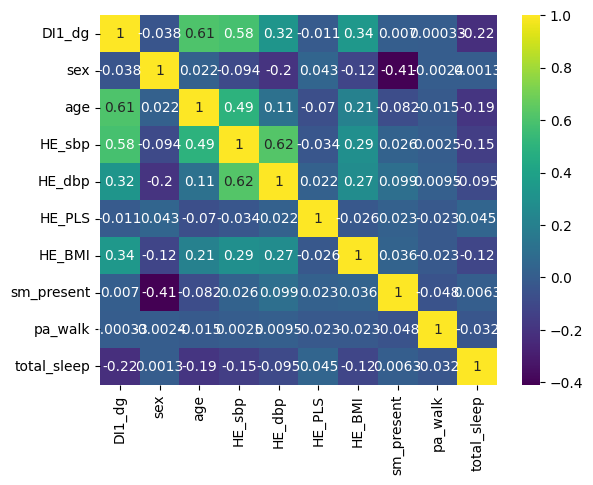

In [24]:
sns.heatmap(df.corr(), annot = True, cmap = 'viridis')

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
pd.crosstab(df['DI1_dg'], df['sex'], margins=True)

In [ ]:
pd.crosstab(df['DI1_dg'], df['sm_present'], margins=True)

In [ ]:
pd.crosstab(df['DI1_dg'], df['pa_walk'], margins=True)

# 분산 동질성 분석 / 통계적 유의성 측정

box-cox 변환을 수행한 후에 분산 동질성 분석과 통계적 유의성을 측정해보기로 했습니다.

In [ ]:
from sklearn.preprocessing import power_transform

df[['age']] = power_transform(df[['age']],method = 'box-cox', standardize = False)
df[['HE_sbp']] = power_transform(df[['HE_sbp']],method = 'box-cox', standardize = False)
df[['HE_dbp']] = power_transform(df[['HE_dbp']],method = 'box-cox', standardize = False)
df[['HE_BMI']] = power_transform(df[['HE_BMI']],method = 'box-cox', standardize = False)
df[['total_sleep']] = power_transform(df[['total_sleep']],method = 'box-cox', standardize = False)

In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import levene
from scipy.stats import jarque_bera
from scipy.stats import ttest_ind

In [ ]:
df0 = df[df['DI1_dg'] == 0]
df1 = df[df['DI1_dg'] == 1]

In [ ]:
stat_sbp, p_sbp = levene(df0['HE_sbp'], df1['HE_sbp'])
print('HE_sbp 분산 동질성 분석')
if p_sbp > 0.05:
    print("결과: 두집단의 분산의 동질성 검정결과는 유의하다. 집단의 분산은 동질하다.\n")
else:
    print("결과: 집단의 분산의 동질성검정결과는 유의하지 않다.\n")

stat_dbp, p_dbp = levene(df0['HE_dbp'], df1['HE_dbp'])
print('HE_dbp 분산 동질성 분석')
if p_dbp > 0.05:
    print("결과: 두집단의 분산의 동질성 검정결과는 유의하다. 집단의 분산은 동질하다.\n")
else:
    print("결과: 집단의 분산의 동질성검정결과는 유의하지 않다.\n")

stat_BMI, p_BMI = levene(df0['HE_BMI'], df1['HE_BMI'])
print('HE_BMI 분산 동질성 분석')
if p_BMI > 0.05:
    print("결과: 두집단의 분산의 동질성 검정결과는 유의하다. 집단의 분산은 동질하다.\n")
else:
    print("결과: 집단의 분산의 동질성검정결과는 유의하지 않다.\n")

stat_sleep, p_sleep = levene(df0['total_sleep'], df1['total_sleep'])
print('total_sleep 분산 동질성 분석')
if p_sleep > 0.05:
    print("결과: 두집단의 분산의 동질성 검정결과는 유의하다. 집단의 분산은 동질하다.\n")
else:
    print("결과: 집단의 분산의 동질성검정결과는 유의하지 않다.\n")

stat_age, p_age = levene(df0['age'], df1['age'])
print('age 분산 동질성 분석')
if p_age > 0.05:
    print("결과: 두집단의 분산의 동질성 검정결과는 유의하다. 집단의 분산은 동질하다.\n")
else:
    print("결과: 집단의 분산의 동질성검정결과는 유의하지 않다.\n")

HE_sbp 분산 동질성 분석
결과: 집단의 분산의 동질성검정결과는 유의하지 않다.

HE_dbp 분산 동질성 분석
결과: 집단의 분산의 동질성검정결과는 유의하지 않다.

HE_BMI 분산 동질성 분석
결과: 집단의 분산의 동질성검정결과는 유의하지 않다.

total_sleep 분산 동질성 분석
결과: 집단의 분산의 동질성검정결과는 유의하지 않다.

age 분산 동질성 분석
결과: 집단의 분산의 동질성검정결과는 유의하지 않다.



분산의 동질성이 없으므로,  Welch’s t-검정 방법을 사용해 수행합니다.

In [ ]:
st_sbp, pp_sbp = ttest_ind(df0['HE_sbp'], df1['HE_sbp'], equal_var = False)
print('HE_sbp 통계적 유의성 분석')
if pp_sbp > 0.05:
    print("통계적으로 유의하지 않았다.\n")
else:
    print("통계적으로 유의한 차이가 발생했다.\n")

st_dbp, pp_dbp = ttest_ind(df0['HE_dbp'], df1['HE_dbp'], equal_var = False)
print('HE_dbp 통계적 유의성 분석')
if pp_dbp > 0.05:
    print("통계적으로 유의하지 않았다.\n")
else:
    print("통계적으로 유의한 차이가 발생했다.\n")

st_BMI, pp_BMI = ttest_ind(df0['HE_BMI'], df1['HE_BMI'], equal_var = False)
print('HE_BMI 통계적 유의성 분석')
if pp_BMI > 0.05:
    print("통계적으로 유의하지 않았다.\n")
else:
    print("통계적으로 유의한 차이가 발생했다.\n")

st_sleep, pp_sleep = ttest_ind(df0['total_sleep'], df1['total_sleep'], equal_var = False)
print('total_sleep 통계적 유의성 분석')
if pp_sleep > 0.05:
    print("통계적으로 유의하지 않았다.\n")
else:
    print("통계적으로 유의한 차이가 발생했다.\n")

st_age, pp_age = ttest_ind(df0['age'], df1['age'], equal_var = False)
print('age 통계적 유의성 분석')
if pp_age > 0.05:
    print("통계적으로 유의하지 않았다.\n")
else:
    print("통계적으로 유의한 차이가 발생했다.\n")

HE_sbp 통계적 유의성 분석
통계적으로 유의한 차이가 발생했다.

HE_dbp 통계적 유의성 분석
통계적으로 유의한 차이가 발생했다.

HE_BMI 통계적 유의성 분석
통계적으로 유의한 차이가 발생했다.

total_sleep 통계적 유의성 분석
통계적으로 유의한 차이가 발생했다.

age 통계적 유의성 분석
통계적으로 유의한 차이가 발생했다.



# 수정사항 + DNN 모델

'sex', 'age', 'HE_sbp', 'HE_dbp', 'HE_BMI', 'total_sleep', 'sm_present', 'pa_walk'


▲ 변수 개수를 조정해가며 학습시켜본 결과, 위의 8개 변수들을 선정했을 때, 모델 성능이 가장 좋았습니다.
15초 맥박수(HE_PLS)는 고혈압 환자군이 정상군보다 맥박수가 높다는 가정에 위배되어 제외하였습니다.

sigmoid, tanh, relu, leaky_relu, elu의 활성화함수를 사용했고, leaky_relu가 가장 좋은 성능을 보여 leaky_relu를 사용하기로 결정하였습니다.

1. DNN - 1 / 8 / X / leaky_relu

In [ ]:
mlp1 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp1.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp1.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8622

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.5705 - accuracy: 0.6753 - val_loss: 0.3783 - val_accuracy: 0.8306
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3470 - accuracy: 0.8412 - val_loss: 0.3236 - val_accuracy: 0.8511
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3221 - accuracy: 0.8510 - val_loss: 0.3136 - val_accuracy: 0.8537
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3159 - accuracy: 0.8530 - val_loss: 0.3096 - val_accuracy: 0.8559
Epoch 5/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3127 - accuracy: 0.8539 - val_loss: 0.3070 - val_accuracy: 0.8569
Epoch 6/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3107 - accuracy: 0.8545 - val_loss: 0.3053 - val_accuracy: 0.8578
Epoch 7/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3093 - accuracy: 0.8555 - val_loss: 0.3043 - val_accuracy: 0.8580
Epoch 

2. DNN - 1 / 16 / X / leaky_relu

In [ ]:
mlp2 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp2.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp2.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8669

Epoch 1/50
290/290 [==============================] - 3s 8ms/step - loss: 0.4911 - accuracy: 0.7574 - val_loss: 0.3429 - val_accuracy: 0.8513
Epoch 2/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3264 - accuracy: 0.8493 - val_loss: 0.3133 - val_accuracy: 0.8560
Epoch 3/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3154 - accuracy: 0.8524 - val_loss: 0.3097 - val_accuracy: 0.8558
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3127 - accuracy: 0.8534 - val_loss: 0.3079 - val_accuracy: 0.8578
Epoch 5/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3109 - accuracy: 0.8540 - val_loss: 0.3061 - val_accuracy: 0.8581
Epoch 6/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3094 - accuracy: 0.8548 - val_loss: 0.3048 - val_accuracy: 0.8579
Epoch 7/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3081 - accuracy: 0.8558 - val_loss: 0.3037 - val_accuracy: 0.8592
Epoch 

3. DNN - 2 / 8 / X / leaky_relu

In [ ]:
mlp3 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp3.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp3.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8647

Epoch 1/50
290/290 [==============================] - 3s 6ms/step - loss: 0.5156 - accuracy: 0.7290 - val_loss: 0.3372 - val_accuracy: 0.8456
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3251 - accuracy: 0.8489 - val_loss: 0.3137 - val_accuracy: 0.8549
Epoch 3/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3158 - accuracy: 0.8525 - val_loss: 0.3093 - val_accuracy: 0.8584
Epoch 4/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3128 - accuracy: 0.8532 - val_loss: 0.3074 - val_accuracy: 0.8566
Epoch 5/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3106 - accuracy: 0.8540 - val_loss: 0.3049 - val_accuracy: 0.8593
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3088 - accuracy: 0.8546 - val_loss: 0.3033 - val_accuracy: 0.8591
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3070 - accuracy: 0.8556 - val_loss: 0.3024 - val_accuracy: 0.8594
Epoch 

4. DNN - 2 / 16 / X / leaky_relu

In [ ]:
mlp4 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp4.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp4.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8667

Epoch 1/50
290/290 [==============================] - 2s 5ms/step - loss: 0.3891 - accuracy: 0.8255 - val_loss: 0.3156 - val_accuracy: 0.8556
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3151 - accuracy: 0.8532 - val_loss: 0.3070 - val_accuracy: 0.8590
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3092 - accuracy: 0.8557 - val_loss: 0.3031 - val_accuracy: 0.8591
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3056 - accuracy: 0.8560 - val_loss: 0.3000 - val_accuracy: 0.8623
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3027 - accuracy: 0.8574 - val_loss: 0.2974 - val_accuracy: 0.8612
Epoch 6/50
290/290 [==============================] - 1s 2ms/step - loss: 0.3005 - accuracy: 0.8577 - val_loss: 0.2965 - val_accuracy: 0.8625
Epoch 7/50
290/290 [==============================] - 1s 2ms/step - loss: 0.2983 - accuracy: 0.8592 - val_loss: 0.2935 - val_accuracy: 0.8625
Epoch 

5. DNN - 3 / 8 / X / leaky_relu

In [ ]:
mlp5 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp5.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp5.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp5.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8647

Epoch 1/50
290/290 [==============================] - 4s 6ms/step - loss: 0.4462 - accuracy: 0.8027 - val_loss: 0.3261 - val_accuracy: 0.8476
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3250 - accuracy: 0.8500 - val_loss: 0.3156 - val_accuracy: 0.8559
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3169 - accuracy: 0.8532 - val_loss: 0.3097 - val_accuracy: 0.8598
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3120 - accuracy: 0.8543 - val_loss: 0.3064 - val_accuracy: 0.8568
Epoch 5/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3083 - accuracy: 0.8556 - val_loss: 0.3036 - val_accuracy: 0.8591
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3059 - accuracy: 0.8570 - val_loss: 0.3019 - val_accuracy: 0.8593
Epoch 7/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3041 - accuracy: 0.8578 - val_loss: 0.3009 - val_accuracy: 0.8584
Epoch 

6. DNN - 3 / 16 / X / leaky_relu

In [ ]:
mlp6 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp6.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp6.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp6.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8697

Epoch 1/50
290/290 [==============================] - 2s 3ms/step - loss: 0.3826 - accuracy: 0.8290 - val_loss: 0.3134 - val_accuracy: 0.8564
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3125 - accuracy: 0.8529 - val_loss: 0.3038 - val_accuracy: 0.8559
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3059 - accuracy: 0.8548 - val_loss: 0.2989 - val_accuracy: 0.8597
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3012 - accuracy: 0.8565 - val_loss: 0.2949 - val_accuracy: 0.8622
Epoch 5/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2977 - accuracy: 0.8581 - val_loss: 0.2912 - val_accuracy: 0.8625
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.2946 - accuracy: 0.8593 - val_loss: 0.2898 - val_accuracy: 0.8639
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2919 - accuracy: 0.8610 - val_loss: 0.2891 - val_accuracy: 0.8654
Epoch 

7. DNN - 4 / 8 / X / leaky_relu

In [ ]:
mlp7 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp7.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp7.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp7.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8666

Epoch 1/50
290/290 [==============================] - 5s 9ms/step - loss: 0.4011 - accuracy: 0.8110 - val_loss: 0.3187 - val_accuracy: 0.8531
Epoch 2/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3189 - accuracy: 0.8511 - val_loss: 0.3129 - val_accuracy: 0.8543
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3145 - accuracy: 0.8524 - val_loss: 0.3089 - val_accuracy: 0.8567
Epoch 4/50
290/290 [==============================] - 3s 11ms/step - loss: 0.3114 - accuracy: 0.8536 - val_loss: 0.3060 - val_accuracy: 0.8586
Epoch 5/50
290/290 [==============================] - 2s 8ms/step - loss: 0.3085 - accuracy: 0.8550 - val_loss: 0.3050 - val_accuracy: 0.8585
Epoch 6/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3057 - accuracy: 0.8560 - val_loss: 0.3021 - val_accuracy: 0.8584
Epoch 7/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3036 - accuracy: 0.8566 - val_loss: 0.3015 - val_accuracy: 0.8571
Epoch

8. DNN - 4 / 16 / X / leaky_relu

In [ ]:
mlp8 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp8.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp8.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp8.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8692

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.3970 - accuracy: 0.8198 - val_loss: 0.3090 - val_accuracy: 0.8565
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3078 - accuracy: 0.8553 - val_loss: 0.2996 - val_accuracy: 0.8604
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3014 - accuracy: 0.8582 - val_loss: 0.2951 - val_accuracy: 0.8628
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2972 - accuracy: 0.8585 - val_loss: 0.2938 - val_accuracy: 0.8612
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2932 - accuracy: 0.8608 - val_loss: 0.2929 - val_accuracy: 0.8604
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2897 - accuracy: 0.8618 - val_loss: 0.2864 - val_accuracy: 0.8635
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2864 - accuracy: 0.8621 - val_loss: 0.2857 - val_accuracy: 0.8610
Epoch 

9. DNN - 5 / 8 / X / leaky_relu

In [ ]:
mlp9 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp9.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp9.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp9.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8669

Epoch 1/50
290/290 [==============================] - 2s 3ms/step - loss: 0.3922 - accuracy: 0.8338 - val_loss: 0.3232 - val_accuracy: 0.8530
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3193 - accuracy: 0.8515 - val_loss: 0.3100 - val_accuracy: 0.8551
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3104 - accuracy: 0.8531 - val_loss: 0.3065 - val_accuracy: 0.8550
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3069 - accuracy: 0.8541 - val_loss: 0.3040 - val_accuracy: 0.8535
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3037 - accuracy: 0.8544 - val_loss: 0.3015 - val_accuracy: 0.8562
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3017 - accuracy: 0.8559 - val_loss: 0.2976 - val_accuracy: 0.8591
Epoch 7/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2994 - accuracy: 0.8569 - val_loss: 0.2971 - val_accuracy: 0.8584
Epoch 

10. DNN - 5 / 16 / X / leaky_relu

In [ ]:
mlp10 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp10.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp10.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = mlp10.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8711

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.3880 - accuracy: 0.8153 - val_loss: 0.3095 - val_accuracy: 0.8518
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3080 - accuracy: 0.8519 - val_loss: 0.2965 - val_accuracy: 0.8595
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2964 - accuracy: 0.8560 - val_loss: 0.2903 - val_accuracy: 0.8622
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2905 - accuracy: 0.8589 - val_loss: 0.2861 - val_accuracy: 0.8633
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2858 - accuracy: 0.8604 - val_loss: 0.2843 - val_accuracy: 0.8647
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2831 - accuracy: 0.8599 - val_loss: 0.2823 - val_accuracy: 0.8652
Epoch 7/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2801 - accuracy: 0.8618 - val_loss: 0.2794 - val_accuracy: 0.8659
Epoch 

11. DNN - 1 / 8 / O / leaky_relu

In [ ]:
mlp11 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp11.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp11.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp11.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8571

Epoch 1/100
290/290 [==============================] - 3s 5ms/step - loss: 0.5053 - accuracy: 0.7439 - val_loss: 0.3702 - val_accuracy: 0.8393
Epoch 2/100
290/290 [==============================] - 1s 5ms/step - loss: 0.3992 - accuracy: 0.8217 - val_loss: 0.3253 - val_accuracy: 0.8511
Epoch 3/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3677 - accuracy: 0.8366 - val_loss: 0.3168 - val_accuracy: 0.8528
Epoch 4/100
290/290 [==============================] - 2s 6ms/step - loss: 0.3553 - accuracy: 0.8408 - val_loss: 0.3136 - val_accuracy: 0.8528
Epoch 5/100
290/290 [==============================] - 2s 7ms/step - loss: 0.3499 - accuracy: 0.8436 - val_loss: 0.3116 - val_accuracy: 0.8531
Epoch 6/100
290/290 [==============================] - 2s 8ms/step - loss: 0.3444 - accuracy: 0.8442 - val_loss: 0.3108 - val_accuracy: 0.8553
Epoch 7/100
290/290 [==============================] - 2s 7ms/step - loss: 0.3394 - accuracy: 0.8445 - val_loss: 0.3100 - val_accuracy: 0.8554

12. DNN - 1 / 16 / O / leaky_relu

In [ ]:
mlp12 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp12.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp12.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp12.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8596

Epoch 1/100
290/290 [==============================] - 2s 3ms/step - loss: 0.4153 - accuracy: 0.8090 - val_loss: 0.3193 - val_accuracy: 0.8528
Epoch 2/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3466 - accuracy: 0.8418 - val_loss: 0.3103 - val_accuracy: 0.8539
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3363 - accuracy: 0.8460 - val_loss: 0.3079 - val_accuracy: 0.8560
Epoch 4/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3307 - accuracy: 0.8489 - val_loss: 0.3066 - val_accuracy: 0.8560
Epoch 5/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3256 - accuracy: 0.8491 - val_loss: 0.3053 - val_accuracy: 0.8569
Epoch 6/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3257 - accuracy: 0.8498 - val_loss: 0.3047 - val_accuracy: 0.8567
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3229 - accuracy: 0.8506 - val_loss: 0.3037 - val_accuracy: 0.8568

13. DNN - 2 / 8 / O / leaky_relu

In [ ]:
mlp13 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp13.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp13.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp13.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8567

Epoch 1/100
290/290 [==============================] - 2s 3ms/step - loss: 0.6574 - accuracy: 0.6251 - val_loss: 0.4371 - val_accuracy: 0.8128
Epoch 2/100
290/290 [==============================] - 1s 2ms/step - loss: 0.4565 - accuracy: 0.7833 - val_loss: 0.3329 - val_accuracy: 0.8543
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3938 - accuracy: 0.8182 - val_loss: 0.3147 - val_accuracy: 0.8563
Epoch 4/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3760 - accuracy: 0.8306 - val_loss: 0.3113 - val_accuracy: 0.8577
Epoch 5/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3676 - accuracy: 0.8341 - val_loss: 0.3097 - val_accuracy: 0.8577
Epoch 6/100
290/290 [==============================] - 1s 2ms/step - loss: 0.3633 - accuracy: 0.8352 - val_loss: 0.3087 - val_accuracy: 0.8575
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3602 - accuracy: 0.8382 - val_loss: 0.3084 - val_accuracy: 0.8580

14. DNN - 2 / 16 / O / leaky_relu

In [ ]:
mlp14 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp14.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp14.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp14.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8594

Epoch 1/100
290/290 [==============================] - 2s 3ms/step - loss: 0.4821 - accuracy: 0.7676 - val_loss: 0.3225 - val_accuracy: 0.8529
Epoch 2/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3685 - accuracy: 0.8364 - val_loss: 0.3135 - val_accuracy: 0.8554
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3493 - accuracy: 0.8426 - val_loss: 0.3097 - val_accuracy: 0.8577
Epoch 4/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3429 - accuracy: 0.8445 - val_loss: 0.3089 - val_accuracy: 0.8567
Epoch 5/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3390 - accuracy: 0.8460 - val_loss: 0.3076 - val_accuracy: 0.8560
Epoch 6/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3375 - accuracy: 0.8461 - val_loss: 0.3062 - val_accuracy: 0.8580
Epoch 7/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3344 - accuracy: 0.8469 - val_loss: 0.3054 - val_accuracy: 0.8566

15. DNN - 3 / 8 / O / leaky_relu

In [ ]:
mlp15 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp15.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp15.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp15.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8564

Epoch 1/100
290/290 [==============================] - 2s 4ms/step - loss: 0.6107 - accuracy: 0.6717 - val_loss: 0.3978 - val_accuracy: 0.8330
Epoch 2/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4569 - accuracy: 0.7853 - val_loss: 0.3251 - val_accuracy: 0.8527
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4117 - accuracy: 0.8125 - val_loss: 0.3126 - val_accuracy: 0.8543
Epoch 4/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3927 - accuracy: 0.8242 - val_loss: 0.3098 - val_accuracy: 0.8551
Epoch 5/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3792 - accuracy: 0.8291 - val_loss: 0.3089 - val_accuracy: 0.8554
Epoch 6/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3749 - accuracy: 0.8322 - val_loss: 0.3087 - val_accuracy: 0.8560
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3705 - accuracy: 0.8353 - val_loss: 0.3093 - val_accuracy: 0.8548

16. DNN - 3 / 16 / O / leaky_relu

In [ ]:
mlp16 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp16.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp16.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp16.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8600

Epoch 1/100
290/290 [==============================] - 2s 4ms/step - loss: 0.5148 - accuracy: 0.7426 - val_loss: 0.3297 - val_accuracy: 0.8514
Epoch 2/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3900 - accuracy: 0.8243 - val_loss: 0.3143 - val_accuracy: 0.8541
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3622 - accuracy: 0.8387 - val_loss: 0.3093 - val_accuracy: 0.8553
Epoch 4/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3534 - accuracy: 0.8424 - val_loss: 0.3079 - val_accuracy: 0.8566
Epoch 5/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3474 - accuracy: 0.8429 - val_loss: 0.3071 - val_accuracy: 0.8560
Epoch 6/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3452 - accuracy: 0.8438 - val_loss: 0.3063 - val_accuracy: 0.8557
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3442 - accuracy: 0.8448 - val_loss: 0.3064 - val_accuracy: 0.8549

17. DNN - 4 / 8 / O / leaky_relu

In [ ]:
mlp17 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp17.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp17.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8570

Epoch 1/100
290/290 [==============================] - 3s 5ms/step - loss: 0.6107 - accuracy: 0.6673 - val_loss: 0.4219 - val_accuracy: 0.8191
Epoch 2/100
290/290 [==============================] - 1s 3ms/step - loss: 0.5062 - accuracy: 0.7439 - val_loss: 0.3377 - val_accuracy: 0.8443
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.7861 - val_loss: 0.3213 - val_accuracy: 0.8512
Epoch 4/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4182 - accuracy: 0.8056 - val_loss: 0.3162 - val_accuracy: 0.8527
Epoch 5/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4150 - accuracy: 0.8118 - val_loss: 0.3145 - val_accuracy: 0.8539
Epoch 6/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4042 - accuracy: 0.8171 - val_loss: 0.3142 - val_accuracy: 0.8543
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3971 - accuracy: 0.8192 - val_loss: 0.3126 - val_accuracy: 0.8557

18. DNN - 4 / 16 / O / leaky_relu

In [ ]:
mlp18 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp18.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp18.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp18.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8593

Epoch 1/100
290/290 [==============================] - 3s 4ms/step - loss: 0.5672 - accuracy: 0.7004 - val_loss: 0.3384 - val_accuracy: 0.8524
Epoch 2/100
290/290 [==============================] - 1s 3ms/step - loss: 0.4124 - accuracy: 0.8158 - val_loss: 0.3150 - val_accuracy: 0.8551
Epoch 3/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3777 - accuracy: 0.8346 - val_loss: 0.3122 - val_accuracy: 0.8554
Epoch 4/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3662 - accuracy: 0.8347 - val_loss: 0.3091 - val_accuracy: 0.8571
Epoch 5/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3613 - accuracy: 0.8413 - val_loss: 0.3110 - val_accuracy: 0.8556
Epoch 6/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3561 - accuracy: 0.8410 - val_loss: 0.3090 - val_accuracy: 0.8550
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3496 - accuracy: 0.8448 - val_loss: 0.3057 - val_accuracy: 0.8577

19. DNN - 5 / 8 / O / leaky_relu

In [ ]:
mlp19 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp19.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp19.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp19.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8606

Epoch 1/100
290/290 [==============================] - 4s 4ms/step - loss: 0.6248 - accuracy: 0.6573 - val_loss: 0.4049 - val_accuracy: 0.8357
Epoch 2/100
290/290 [==============================] - 1s 4ms/step - loss: 0.4423 - accuracy: 0.7932 - val_loss: 0.3240 - val_accuracy: 0.8509
Epoch 3/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3906 - accuracy: 0.8256 - val_loss: 0.3143 - val_accuracy: 0.8541
Epoch 4/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3802 - accuracy: 0.8327 - val_loss: 0.3116 - val_accuracy: 0.8556
Epoch 5/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3677 - accuracy: 0.8366 - val_loss: 0.3136 - val_accuracy: 0.8569
Epoch 6/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3643 - accuracy: 0.8406 - val_loss: 0.3101 - val_accuracy: 0.8569
Epoch 7/100
290/290 [==============================] - 1s 5ms/step - loss: 0.3593 - accuracy: 0.8418 - val_loss: 0.3093 - val_accuracy: 0.8569

20. DNN - 5 / 16 / O / leaky_relu

In [ ]:
mlp20 = Sequential([
    keras.layers.Input(shape=(8,)),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

mlp20.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = mlp20.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test)).history

res = mlp20.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8604

Epoch 1/100
290/290 [==============================] - 3s 6ms/step - loss: 0.6121 - accuracy: 0.6609 - val_loss: 0.3662 - val_accuracy: 0.8427
Epoch 2/100
290/290 [==============================] - 2s 6ms/step - loss: 0.4417 - accuracy: 0.7998 - val_loss: 0.3223 - val_accuracy: 0.8514
Epoch 3/100
290/290 [==============================] - 2s 6ms/step - loss: 0.3982 - accuracy: 0.8236 - val_loss: 0.3144 - val_accuracy: 0.8521
Epoch 4/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3776 - accuracy: 0.8326 - val_loss: 0.3119 - val_accuracy: 0.8521
Epoch 5/100
290/290 [==============================] - 1s 4ms/step - loss: 0.3711 - accuracy: 0.8362 - val_loss: 0.3106 - val_accuracy: 0.8563
Epoch 6/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3650 - accuracy: 0.8384 - val_loss: 0.3107 - val_accuracy: 0.8563
Epoch 7/100
290/290 [==============================] - 1s 3ms/step - loss: 0.3620 - accuracy: 0.8418 - val_loss: 0.3081 - val_accuracy: 0.8580

# DNN 모델 개선 이전과 비교

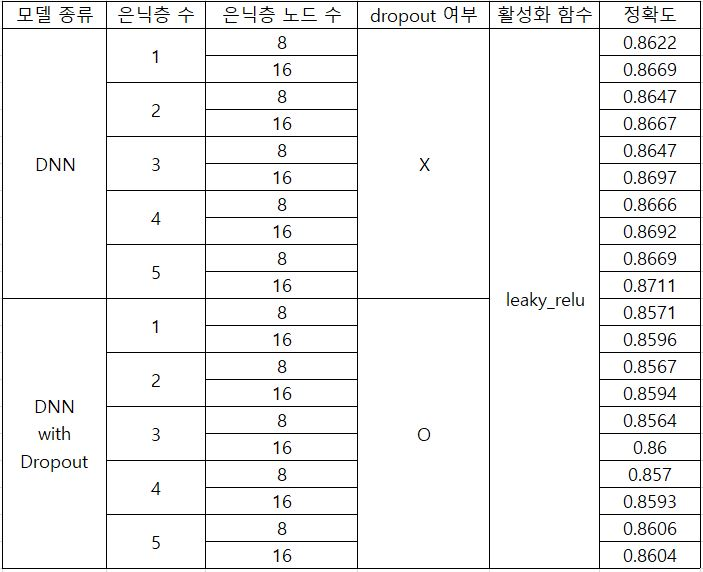

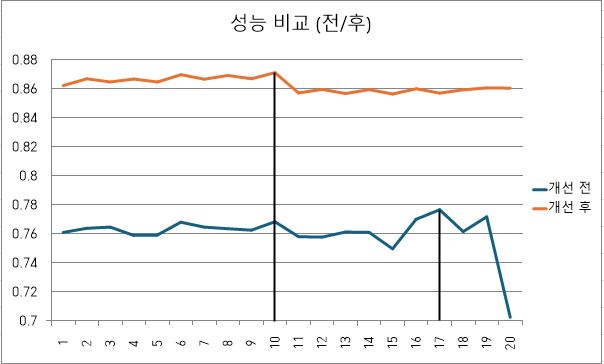

이전과 비교하여 확실히 성능이 개선되었으며, 최고 성능은 10번째 모델로 0.8711의 정확도를 보여줬습니다. 평균적으로 10%p 정도 개선되었습니다.

# CNN 모델

CNN - conv1d 이후에 은닉층에서 노드 수를 선정하기 위해 은닉층 노드 수에 따라 비교를 수행했습니다. 결과적으로 대부분의 경우에서 16개로 설정한 경우가 성능이 더 뛰어났기에 16개로 설정하기로 했습니다.

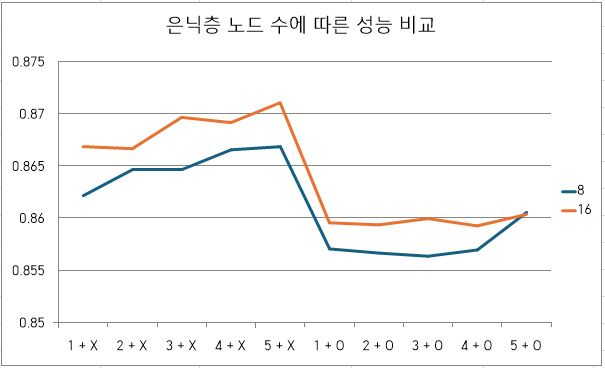

1. CNN - 1 + 1 / 8 / X / leaky_relu

In [ ]:
cnn1 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn1.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn1.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8686

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.4322 - accuracy: 0.7970 - val_loss: 0.3205 - val_accuracy: 0.8534
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3199 - accuracy: 0.8504 - val_loss: 0.3118 - val_accuracy: 0.8551
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3133 - accuracy: 0.8530 - val_loss: 0.3077 - val_accuracy: 0.8576
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3096 - accuracy: 0.8535 - val_loss: 0.3053 - val_accuracy: 0.8578
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3070 - accuracy: 0.8542 - val_loss: 0.3027 - val_accuracy: 0.8584
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3048 - accuracy: 0.8557 - val_loss: 0.3015 - val_accuracy: 0.8577
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3032 - accuracy: 0.8564 - val_loss: 0.2994 - val_accuracy: 0.8590
Epoch 

2. CNN - 1 + 1 / 16 / X / leaky_relu

In [ ]:
cnn2 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn2.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn2.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8709

Epoch 1/50
290/290 [==============================] - 3s 6ms/step - loss: 0.4141 - accuracy: 0.8143 - val_loss: 0.3154 - val_accuracy: 0.8573
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3149 - accuracy: 0.8548 - val_loss: 0.3072 - val_accuracy: 0.8608
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3087 - accuracy: 0.8552 - val_loss: 0.3034 - val_accuracy: 0.8611
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3050 - accuracy: 0.8570 - val_loss: 0.3001 - val_accuracy: 0.8623
Epoch 5/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3020 - accuracy: 0.8580 - val_loss: 0.2982 - val_accuracy: 0.8632
Epoch 6/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3001 - accuracy: 0.8582 - val_loss: 0.2962 - val_accuracy: 0.8614
Epoch 7/50
290/290 [==============================] - 3s 11ms/step - loss: 0.2979 - accuracy: 0.8590 - val_loss: 0.2957 - val_accuracy: 0.8614
Epoch

0.8709

3. CNN - 1 + 2 / 8 / X / leaky_relu

In [ ]:
cnn3 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn3.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn3.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8694

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.3854 - accuracy: 0.8327 - val_loss: 0.3109 - val_accuracy: 0.8577
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3133 - accuracy: 0.8538 - val_loss: 0.3048 - val_accuracy: 0.8605
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3079 - accuracy: 0.8551 - val_loss: 0.3006 - val_accuracy: 0.8599
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3041 - accuracy: 0.8558 - val_loss: 0.2977 - val_accuracy: 0.8625
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3013 - accuracy: 0.8573 - val_loss: 0.2956 - val_accuracy: 0.8617
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2985 - accuracy: 0.8581 - val_loss: 0.2937 - val_accuracy: 0.8617
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2961 - accuracy: 0.8573 - val_loss: 0.2929 - val_accuracy: 0.8606
Epoch 

4. CNN - 1 + 2 / 16 / X / leaky_relu

In [ ]:
cnn4 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn4.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn4.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8708

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.3830 - accuracy: 0.8244 - val_loss: 0.3105 - val_accuracy: 0.8571
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3114 - accuracy: 0.8545 - val_loss: 0.3052 - val_accuracy: 0.8572
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3058 - accuracy: 0.8566 - val_loss: 0.2985 - val_accuracy: 0.8620
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3015 - accuracy: 0.8580 - val_loss: 0.2958 - val_accuracy: 0.8639
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2982 - accuracy: 0.8581 - val_loss: 0.2946 - val_accuracy: 0.8632
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2956 - accuracy: 0.8596 - val_loss: 0.2928 - val_accuracy: 0.8610
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2925 - accuracy: 0.8602 - val_loss: 0.2883 - val_accuracy: 0.8628
Epoch 

5. CNN - 1 + 3 / 8 / X / leaky_relu

In [ ]:
cnn5 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn5.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn5.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn5.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8694

Epoch 1/50
290/290 [==============================] - 3s 6ms/step - loss: 0.3922 - accuracy: 0.8144 - val_loss: 0.3166 - val_accuracy: 0.8520
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3148 - accuracy: 0.8514 - val_loss: 0.3078 - val_accuracy: 0.8540
Epoch 3/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3103 - accuracy: 0.8528 - val_loss: 0.3051 - val_accuracy: 0.8575
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3075 - accuracy: 0.8524 - val_loss: 0.3032 - val_accuracy: 0.8575
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3048 - accuracy: 0.8528 - val_loss: 0.2997 - val_accuracy: 0.8568
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3017 - accuracy: 0.8536 - val_loss: 0.2979 - val_accuracy: 0.8571
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3002 - accuracy: 0.8537 - val_loss: 0.2981 - val_accuracy: 0.8563
Epoch 

6. CNN - 1 + 3 / 16 / X / leaky_relu

In [ ]:
cnn6 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn6.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn6.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn6.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8711

Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 0.3829 - accuracy: 0.8420 - val_loss: 0.3090 - val_accuracy: 0.8592
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3086 - accuracy: 0.8558 - val_loss: 0.3023 - val_accuracy: 0.8620
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3018 - accuracy: 0.8571 - val_loss: 0.2979 - val_accuracy: 0.8572
Epoch 4/50
290/290 [==============================] - 2s 6ms/step - loss: 0.2965 - accuracy: 0.8580 - val_loss: 0.2925 - val_accuracy: 0.8600
Epoch 5/50
290/290 [==============================] - 1s 5ms/step - loss: 0.2925 - accuracy: 0.8599 - val_loss: 0.2891 - val_accuracy: 0.8598
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.2891 - accuracy: 0.8592 - val_loss: 0.2882 - val_accuracy: 0.8609
Epoch 7/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2860 - accuracy: 0.8602 - val_loss: 0.2842 - val_accuracy: 0.8623
Epoch 

7. CNN - 1 + 4 / 8 / X / leaky_relu

In [ ]:
cnn7 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn7.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn7.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn7.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8693

Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 0.3682 - accuracy: 0.8169 - val_loss: 0.3091 - val_accuracy: 0.8586
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3079 - accuracy: 0.8538 - val_loss: 0.3011 - val_accuracy: 0.8595
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3005 - accuracy: 0.8546 - val_loss: 0.2957 - val_accuracy: 0.8599
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2969 - accuracy: 0.8560 - val_loss: 0.2922 - val_accuracy: 0.8582
Epoch 5/50
290/290 [==============================] - 2s 5ms/step - loss: 0.2940 - accuracy: 0.8570 - val_loss: 0.2902 - val_accuracy: 0.8610
Epoch 6/50
290/290 [==============================] - 2s 5ms/step - loss: 0.2916 - accuracy: 0.8581 - val_loss: 0.2898 - val_accuracy: 0.8593
Epoch 7/50
290/290 [==============================] - 1s 5ms/step - loss: 0.2902 - accuracy: 0.8581 - val_loss: 0.2871 - val_accuracy: 0.8575
Epoch 

8. CNN - 1 + 4 / 16 / X / leaky_relu

In [ ]:
cnn8 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn8.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn8.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn8.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8707

Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 0.3730 - accuracy: 0.8378 - val_loss: 0.3082 - val_accuracy: 0.8597
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3083 - accuracy: 0.8544 - val_loss: 0.3005 - val_accuracy: 0.8601
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3018 - accuracy: 0.8564 - val_loss: 0.2947 - val_accuracy: 0.8597
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.8581 - val_loss: 0.2930 - val_accuracy: 0.8645
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2913 - accuracy: 0.8584 - val_loss: 0.2887 - val_accuracy: 0.8636
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.2879 - accuracy: 0.8591 - val_loss: 0.2854 - val_accuracy: 0.8633
Epoch 7/50
290/290 [==============================] - 2s 6ms/step - loss: 0.2850 - accuracy: 0.8593 - val_loss: 0.2829 - val_accuracy: 0.8617
Epoch 

9. CNN - 1 + 5 / 8 / X / leaky_relu

In [ ]:
cnn9 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn9.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn9.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn9.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8714

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.3767 - accuracy: 0.8255 - val_loss: 0.3221 - val_accuracy: 0.8523
Epoch 2/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3129 - accuracy: 0.8526 - val_loss: 0.3115 - val_accuracy: 0.8559
Epoch 3/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3048 - accuracy: 0.8559 - val_loss: 0.3048 - val_accuracy: 0.8587
Epoch 4/50
290/290 [==============================] - 2s 7ms/step - loss: 0.2995 - accuracy: 0.8580 - val_loss: 0.3071 - val_accuracy: 0.8586
Epoch 5/50
290/290 [==============================] - 2s 8ms/step - loss: 0.2951 - accuracy: 0.8599 - val_loss: 0.2933 - val_accuracy: 0.8610
Epoch 6/50
290/290 [==============================] - 2s 8ms/step - loss: 0.2906 - accuracy: 0.8606 - val_loss: 0.2902 - val_accuracy: 0.8641
Epoch 7/50
290/290 [==============================] - 2s 6ms/step - loss: 0.2875 - accuracy: 0.8620 - val_loss: 0.2882 - val_accuracy: 0.8615
Epoch 

10. CNN - 1 + 5 / 16 / X / leaky_relu

In [ ]:
cnn10 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn10.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn10.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn10.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8706

Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 0.3705 - accuracy: 0.8370 - val_loss: 0.3063 - val_accuracy: 0.8571
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3039 - accuracy: 0.8567 - val_loss: 0.2972 - val_accuracy: 0.8604
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2971 - accuracy: 0.8581 - val_loss: 0.2932 - val_accuracy: 0.8605
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.2930 - accuracy: 0.8583 - val_loss: 0.2944 - val_accuracy: 0.8570
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2886 - accuracy: 0.8599 - val_loss: 0.2921 - val_accuracy: 0.8601
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.2874 - accuracy: 0.8596 - val_loss: 0.2863 - val_accuracy: 0.8612
Epoch 7/50
290/290 [==============================] - 1s 5ms/step - loss: 0.2840 - accuracy: 0.8607 - val_loss: 0.2840 - val_accuracy: 0.8620
Epoch 

11. CNN - 1 + 1 / 8 / O / leaky_relu

In [ ]:
cnn11 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn11.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn11.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn11.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8568

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.4774 - accuracy: 0.7710 - val_loss: 0.3210 - val_accuracy: 0.8539
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3691 - accuracy: 0.8373 - val_loss: 0.3109 - val_accuracy: 0.8550
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3562 - accuracy: 0.8431 - val_loss: 0.3091 - val_accuracy: 0.8558
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3505 - accuracy: 0.8430 - val_loss: 0.3082 - val_accuracy: 0.8566
Epoch 5/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3451 - accuracy: 0.8437 - val_loss: 0.3076 - val_accuracy: 0.8564
Epoch 6/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3445 - accuracy: 0.8446 - val_loss: 0.3072 - val_accuracy: 0.8569
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3439 - accuracy: 0.8443 - val_loss: 0.3077 - val_accuracy: 0.8568
Epoch 

12. CNN - 1 + 1 / 16 / O / leaky_relu

In [ ]:
cnn12 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn12.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn12.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn12.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8581

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.4744 - accuracy: 0.7728 - val_loss: 0.3128 - val_accuracy: 0.8548
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3490 - accuracy: 0.8454 - val_loss: 0.3065 - val_accuracy: 0.8573
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3394 - accuracy: 0.8492 - val_loss: 0.3054 - val_accuracy: 0.8582
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3354 - accuracy: 0.8489 - val_loss: 0.3053 - val_accuracy: 0.8571
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3322 - accuracy: 0.8483 - val_loss: 0.3043 - val_accuracy: 0.8578
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3317 - accuracy: 0.8502 - val_loss: 0.3046 - val_accuracy: 0.8565
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3302 - accuracy: 0.8485 - val_loss: 0.3034 - val_accuracy: 0.8568
Epoch 

13. CNN - 1 + 2 / 8 / O / leaky_relu

In [ ]:
cnn13 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn13.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn13.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn13.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8568

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.4941 - accuracy: 0.7592 - val_loss: 0.3214 - val_accuracy: 0.8476
Epoch 2/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3741 - accuracy: 0.8338 - val_loss: 0.3116 - val_accuracy: 0.8556
Epoch 3/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3607 - accuracy: 0.8404 - val_loss: 0.3093 - val_accuracy: 0.8560
Epoch 4/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3547 - accuracy: 0.8430 - val_loss: 0.3092 - val_accuracy: 0.8556
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3534 - accuracy: 0.8431 - val_loss: 0.3085 - val_accuracy: 0.8577
Epoch 6/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3515 - accuracy: 0.8428 - val_loss: 0.3086 - val_accuracy: 0.8559
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3499 - accuracy: 0.8438 - val_loss: 0.3091 - val_accuracy: 0.8559
Epoch 

14. CNN - 1 + 2 / 16 / O / leaky_relu

In [ ]:
cnn14 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn14.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn14.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn14.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8592

Epoch 1/50
290/290 [==============================] - 2s 4ms/step - loss: 0.4867 - accuracy: 0.7566 - val_loss: 0.3148 - val_accuracy: 0.8535
Epoch 2/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3635 - accuracy: 0.8425 - val_loss: 0.3106 - val_accuracy: 0.8548
Epoch 3/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3494 - accuracy: 0.8451 - val_loss: 0.3094 - val_accuracy: 0.8550
Epoch 4/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3436 - accuracy: 0.8457 - val_loss: 0.3087 - val_accuracy: 0.8558
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3376 - accuracy: 0.8473 - val_loss: 0.3063 - val_accuracy: 0.8570
Epoch 6/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3413 - accuracy: 0.8450 - val_loss: 0.3051 - val_accuracy: 0.8573
Epoch 7/50
290/290 [==============================] - 2s 5ms/step - loss: 0.3377 - accuracy: 0.8454 - val_loss: 0.3039 - val_accuracy: 0.8583
Epoch 

15. CNN - 1 + 3 / 8 / O / leaky_relu

In [ ]:
cnn15 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn15.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn15.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn15.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8584

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.5337 - accuracy: 0.7172 - val_loss: 0.3259 - val_accuracy: 0.8532
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3971 - accuracy: 0.8242 - val_loss: 0.3111 - val_accuracy: 0.8566
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3776 - accuracy: 0.8363 - val_loss: 0.3088 - val_accuracy: 0.8559
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3664 - accuracy: 0.8392 - val_loss: 0.3093 - val_accuracy: 0.8545
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3619 - accuracy: 0.8406 - val_loss: 0.3076 - val_accuracy: 0.8560
Epoch 6/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3570 - accuracy: 0.8423 - val_loss: 0.3081 - val_accuracy: 0.8550
Epoch 7/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3569 - accuracy: 0.8409 - val_loss: 0.3080 - val_accuracy: 0.8553
Epoch 

16. CNN - 1 + 3 / 16 / O / leaky_relu

In [ ]:
cnn16 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn16.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn16.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn16.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8607

Epoch 1/50
290/290 [==============================] - 3s 4ms/step - loss: 0.5019 - accuracy: 0.7640 - val_loss: 0.3112 - val_accuracy: 0.8545
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3745 - accuracy: 0.8366 - val_loss: 0.3098 - val_accuracy: 0.8572
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3592 - accuracy: 0.8425 - val_loss: 0.3081 - val_accuracy: 0.8570
Epoch 4/50
290/290 [==============================] - 2s 5ms/step - loss: 0.3506 - accuracy: 0.8456 - val_loss: 0.3076 - val_accuracy: 0.8578
Epoch 5/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3483 - accuracy: 0.8471 - val_loss: 0.3063 - val_accuracy: 0.8573
Epoch 6/50
290/290 [==============================] - 2s 5ms/step - loss: 0.3418 - accuracy: 0.8474 - val_loss: 0.3056 - val_accuracy: 0.8597
Epoch 7/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3465 - accuracy: 0.8461 - val_loss: 0.3044 - val_accuracy: 0.8594
Epoch 

17. CNN - 1 + 4 / 8 / O / leaky_relu

In [ ]:
cnn17 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn17.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn17.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn17.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8591

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.5708 - accuracy: 0.7213 - val_loss: 0.3313 - val_accuracy: 0.8527
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.4181 - accuracy: 0.8162 - val_loss: 0.3127 - val_accuracy: 0.8544
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3891 - accuracy: 0.8293 - val_loss: 0.3098 - val_accuracy: 0.8565
Epoch 4/50
290/290 [==============================] - 1s 5ms/step - loss: 0.3772 - accuracy: 0.8344 - val_loss: 0.3105 - val_accuracy: 0.8551
Epoch 5/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3732 - accuracy: 0.8350 - val_loss: 0.3118 - val_accuracy: 0.8583
Epoch 6/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3709 - accuracy: 0.8387 - val_loss: 0.3104 - val_accuracy: 0.8579
Epoch 7/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3661 - accuracy: 0.8402 - val_loss: 0.3084 - val_accuracy: 0.8566
Epoch 

18. CNN - 1 + 4 / 16 / O / leaky_relu

In [ ]:
cnn18 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn18.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn18.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn18.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8603

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.5367 - accuracy: 0.7503 - val_loss: 0.3264 - val_accuracy: 0.8546
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.4034 - accuracy: 0.8267 - val_loss: 0.3143 - val_accuracy: 0.8562
Epoch 3/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3779 - accuracy: 0.8372 - val_loss: 0.3117 - val_accuracy: 0.8559
Epoch 4/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3674 - accuracy: 0.8391 - val_loss: 0.3131 - val_accuracy: 0.8541
Epoch 5/50
290/290 [==============================] - 1s 3ms/step - loss: 0.3650 - accuracy: 0.8409 - val_loss: 0.3102 - val_accuracy: 0.8564
Epoch 6/50
290/290 [==============================] - 2s 8ms/step - loss: 0.3610 - accuracy: 0.8441 - val_loss: 0.3075 - val_accuracy: 0.8572
Epoch 7/50
290/290 [==============================] - 3s 11ms/step - loss: 0.3573 - accuracy: 0.8447 - val_loss: 0.3084 - val_accuracy: 0.8567
Epoch

19. CNN - 1 + 5 / 8 / O / leaky_relu

In [ ]:
cnn19 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(8, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn19.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn19.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn19.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8609

Epoch 1/50
290/290 [==============================] - 3s 5ms/step - loss: 0.5881 - accuracy: 0.7087 - val_loss: 0.3464 - val_accuracy: 0.8541
Epoch 2/50
290/290 [==============================] - 1s 4ms/step - loss: 0.4356 - accuracy: 0.8087 - val_loss: 0.3163 - val_accuracy: 0.8557
Epoch 3/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3915 - accuracy: 0.8296 - val_loss: 0.3118 - val_accuracy: 0.8555
Epoch 4/50
290/290 [==============================] - 2s 6ms/step - loss: 0.3853 - accuracy: 0.8327 - val_loss: 0.3104 - val_accuracy: 0.8557
Epoch 5/50
290/290 [==============================] - 2s 5ms/step - loss: 0.3796 - accuracy: 0.8367 - val_loss: 0.3139 - val_accuracy: 0.8530
Epoch 6/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3742 - accuracy: 0.8386 - val_loss: 0.3130 - val_accuracy: 0.8543
Epoch 7/50
290/290 [==============================] - 1s 4ms/step - loss: 0.3726 - accuracy: 0.8395 - val_loss: 0.3118 - val_accuracy: 0.8536
Epoch 

20. CNN - 1 + 5 / 16 / O / leaky_relu

In [ ]:
cnn20 = Sequential([
    keras.layers.Input(shape=(8, 1)),
    keras.layers.Conv1D(16, 8, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(16, activation='leaky_relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

cnn20.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
hist = cnn20.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test)).history

res = cnn20.evaluate(x_test, y_test)
print('정확률=', res[1])
# 0.8616

Epoch 1/50
290/290 [==============================] - 6s 9ms/step - loss: 0.5191 - accuracy: 0.7399 - val_loss: 0.3156 - val_accuracy: 0.8529
Epoch 2/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3977 - accuracy: 0.8294 - val_loss: 0.3104 - val_accuracy: 0.8573
Epoch 3/50
290/290 [==============================] - 3s 10ms/step - loss: 0.3759 - accuracy: 0.8381 - val_loss: 0.3096 - val_accuracy: 0.8569
Epoch 4/50
290/290 [==============================] - 4s 14ms/step - loss: 0.3681 - accuracy: 0.8385 - val_loss: 0.3067 - val_accuracy: 0.8591
Epoch 5/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3608 - accuracy: 0.8416 - val_loss: 0.3053 - val_accuracy: 0.8592
Epoch 6/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3565 - accuracy: 0.8436 - val_loss: 0.3060 - val_accuracy: 0.8592
Epoch 7/50
290/290 [==============================] - 2s 7ms/step - loss: 0.3550 - accuracy: 0.8418 - val_loss: 0.3044 - val_accuracy: 0.8603
Epoc

# DNN과 CNN 비교

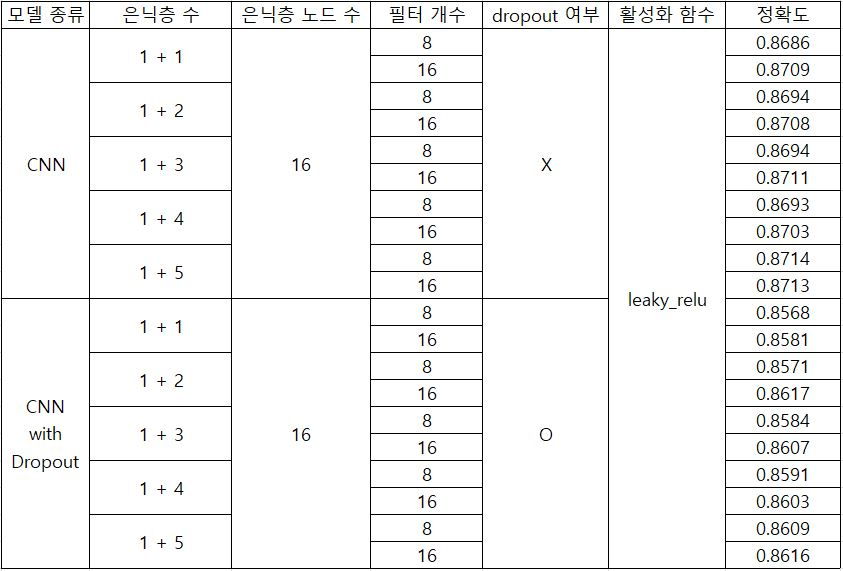

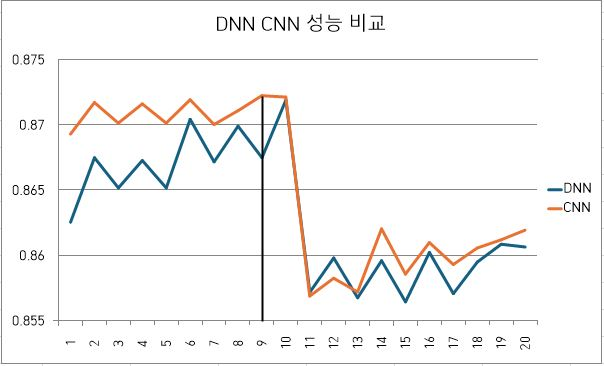

전체적으로 CNN을 사용한 모델이 성능이 더 좋았고, CNN의 9번째 모델이 accuracy 0.8714로 비교적 가장 좋은 성능을 보여줍니다.

연속형 데이터들의 평균과 표준편차 값 ▼

In [ ]:
df.describe()
# 제곱값을 취했기 때문에 값이 큽니다.

,DI1_dg,sex,age,HE_sbp,HE_dbp,HE_PLS,HE_BMI,sm_present,pa_walk,total_sleep
count,46354.000000,46354.000000,46354.000000,46354.00000,46354.000000,46354.000000,46354.000000,46354.000000,46354.000000,46354.000000
mean,0.347910,0.592009,2850.478988,14246.06733,5725.101507,315.843875,575.804000,0.184623,0.559089,47.680787
std,0.476312,0.491467,1632.110824,4091.54374,1439.500727,82.486101,159.758407,0.387995,0.496502,17.105735
min,0.000000,0.000000,361.000000,5112.25000,1444.000000,64.000000,130.951911,0.000000,0.000000,4.000000
25%,0.000000,0.000000,1444.000000,11342.25000,4761.000000,256.000000,461.285061,0.000000,0.000000,36.000000
50%,0.000000,1.000000,2704.000000,13456.00000,5625.000000,289.000000,557.790762,0.000000,1.000000,49.000000
75%,1.000000,1.000000,4096.000000,16384.00000,6561.000000,361.000000,668.756647,0.000000,1.000000,64.000000
max,1.000000,1.000000,7921.000000,51984.00000,21904.000000,2809.000000,2866.284614,1.000000,1.000000,441.000000


- age(나이) 평균: 2850.478988  / 표준편차: 1632.110824
- HE_sbp(수축기 혈압) 평균: 14246.06733  / 표준편차: 4091.54374
- HE_dbp(확장기 혈압) 평균: 5725.101507  / 표준편차: 1439.500727
- HE_BMI(체질량지수) 평균: 575.804000  / 표준편차: 159.758407
- total_sleep(수면시간) 평균: 47.680787  / 표준편차: 17.105735

- sex(성별) 남자 - 0 / 여자 - 1
- sm_present(흡연 여부) 흡연 X - 0 / 흡연 O - 1
- pa_walk(유산소운동 여부) 운동 X - 0 / 운동 O - 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 데이터 전처리 과정 요약

데이터 수집 -> 이상치 제거 -> 연속형 데이터들 제곱 취하기 -> 이상치 제거 -> 평균과 표준편차 값으로 z-score 정규화


제곱을 취한 이유는 차이를 두드러지게 하기 위해서 입니다.

데이터 처리 과정
1. health connect에서 사용자 데이터 받아오기 (+ 키와 몸무게로 BMI 구하기)
2. 서버로 전달
3. 서버에서 데이터 전처리
4. 연속형 데이터들 평균값 구하기
5. 연속형 데이터들 제곱값 취하기
6. 사전에 구해둔 (5/26 - 3) 평균값과 표준편차값으로 정규화하기 ( (값 - 평균) / 표준편차)
7. AI 모델로 전처리한 데이터 전송
8. AI 모델에서 나온 예측값을 앱으로 전송

# tfjs로 모델 convert

In [ ]:
cnn9.save('/content/drive/MyDrive/hypertension_predict.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
save_model = keras.models.load_model('/content/drive/MyDrive/hypertension_predict.h5')
tfjs.converters.save_keras_model(save_model, '/content/drive/MyDrive/predict_model')